# 1. Does the implemented language model predict the next token based on all the past tokens up to the very first token in The Time Machine?

The prediction of the next token is influenced by a fixed-length context window, which is controled by the hyperparameter of prefix

# 2. Which hyperparameter controls the length of history used for prediction?

prefix

# 3. Show that one-hot encoding is equivalent to picking a different embedding for each object.

In [ ]:
import torch
import torch.nn.functional as F

# Create a tensor of indices representing the categories A, B, C, and D
indices = torch.tensor([0, 1, 2, 3])

# Create a one-hot encoded tensor from the indices
one_hot = F.one_hot(indices)

# Create an embedding matrix of size 4 x 3
embedding = torch.tensor([[0.2, -0.5, 0.7],
                          [-0.1, 0.3, -0.6],
                          [0.4, -0.2, 0.1],
                          [-0.3, 0.6, -0.4]])

result = torch.matmul(one_hot[2].float(), embedding)
# Print the result
print(result)

# 4. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity. How low can you go while sticking with this simple architecture?

In [2]:
import numpy as np
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
from torch.nn import functional as F
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore")

class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        
    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
    
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
        return l
        
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(d2l.reshape(torch.argmax(Y, axis=2), 1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])
    
def experient(num_steps=32, num_hiddens=32, lr=1):
    data = d2l.TimeMachine(batch_size=1024, num_steps=num_steps)
    rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=num_hiddens)
    model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=lr)
    trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
    trainer.fit(model, data)
    X,y = next(iter(data.get_dataloader(False)))
    y_hat = model(X) 
    return torch.exp(model.loss(y_hat,y)).item()

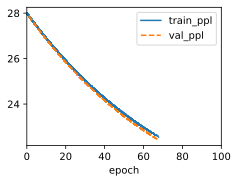

In [ ]:
param_grid = {'num_steps':[8, 16, 32, 64, 128],
              'num_hiddens':[8, 16, 32, 64, 128],
              'lr':[0.01,0.1,1,10]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experient(**params)
    ppls.append(ppl)
    print(params, ppl)

# 5. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?

In [69]:
class EmbRNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True, emb_len=8):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.emb_len) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.emb_len))
        self.lembs = nn.Parameter(torch.randn(self.vocab_size, self.emb_len))

    def forward(self, X, state=None):
        embs = torch.matmul(self.one_hot(X).float(),self.lembs)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=False)
        return l
        
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

6.645046234130859

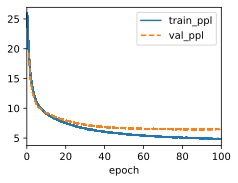

In [71]:
emb_len=len(data.vocab)
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = EmbRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1, emb_len=emb_len)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)
X,y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()

In [75]:
ppls = []
for batch in iter(data.get_dataloader(False)):
    ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
np.exp(np.mean(ppls))

6.4463444

# 6. Conduct an experiment to determine how well this language model trained on The Time Machine works on other books by H. G. Wells, e.g., The War of the Worlds.

In [3]:
import hashlib
import os
import re

class Book(d2l.DataModule):
    def _download(self):
        fname = d2l.download(self.url, self.root, hash_file(os.path.join(self.root, self.url.split('/')[-1])))
        with open(fname) as f:
            return f.read()
        
    def __init__(self, url, batch_size, num_steps, num_train=10000, num_val=5000):
        """Defined in :numref:`sec_language-model`"""
        super().__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]
        
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)
    
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = d2l.Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
        
    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)
        
def hash_file(fname):
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        return sha1.hexdigest()

In [90]:
url = 'https://www.gutenberg.org/cache/epub/36/pg36.txt'
data = Book(url=url, batch_size=1024, num_steps=32)
ppls = []
for batch in iter(data.get_dataloader(False)):
    ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
np.exp(np.mean(ppls))

8.939946

# 7. Conduct another experiment to evaluate the perplexity of this model on books written by other authors.

In [91]:
url = 'https://www.gutenberg.org/cache/epub/71557/pg71557.txt'
data = Book(url=url, batch_size=1024, num_steps=32)
ppls = []
for batch in iter(data.get_dataloader(False)):
    ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
np.exp(np.mean(ppls))

9.404062

# 8. Modify the prediction method so as to use sampling rather than picking the most likely next character.

In [18]:
class SampRNNLMScratch(RNNLMScratch):  #@save
    def predict(self, prefix, num_preds, vocab, device=None, alpha=1, sample=False):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = None, [vocab.token_to_idx[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                if sample:
                    prob = F.softmax(Y[0],dim=-1)
                    prob = prob.pow(alpha)
                    # print(prob.shape,prob.sum(dim=-1).shape)
                    # Normalize the probabilities
                    prob /= prob.sum(dim=-1).reshape(-1,1)
                    # outputs.append(model.one_hot(torch.multinomial(prob, num_samples=1)))
                    # print(torch.multinomial(prob, num_samples=1).shape)
                    outputs.append(torch.multinomial(prob, num_samples=1))
                else:
                    outputs.append(torch.argmax(Y, axis=-1))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

## 8.1 What happens?

When you modify the prediction method to use sampling rather than picking the most likely next character, the generated text becomes more diverse and less deterministic. Instead of always choosing the most probable next character, you are now randomly sampling from the probability distribution over characters at each step. This introduces an element of randomness into the text generation process, leading to more varied and creative output.

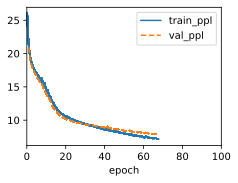

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
emb_len=len(data.vocab)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = SampRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

In [6]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab, sample=True)

'helloriftintre ppacentasce moult on t'

In [17]:
a= SampRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
a.predict(prefix='hello', num_preds=32, vocab=data.vocab)

tensor([[3]]) tensor([[[ 0.0131, -0.0075, -0.0239,  0.0753,  0.0019,  0.0480, -0.0181,
          -0.0231, -0.0055,  0.0026,  0.0053,  0.0078,  0.0473, -0.0103,
           0.0318, -0.0583,  0.0343,  0.0546, -0.0598, -0.0180,  0.0234,
          -0.0210, -0.0298, -0.0026,  0.0271,  0.0515, -0.0329,  0.0341]]],
       grad_fn=<StackBackward0>)
tensor([[6]]) tensor([[[ 0.0286,  0.0208,  0.0151,  0.0216, -0.0097,  0.0018,  0.0843,
          -0.0678, -0.0008,  0.0485,  0.0056,  0.0561,  0.0139, -0.0113,
           0.0417, -0.0141, -0.0010,  0.0122, -0.0470,  0.0308, -0.0124,
           0.0363, -0.0089, -0.0298,  0.0460, -0.0074, -0.0302, -0.0077]]],
       grad_fn=<StackBackward0>)
tensor([[3]]) tensor([[[ 2.6855e-02,  3.2494e-02, -1.9346e-02,  4.7387e-02,  1.9491e-02,
           1.3975e-02, -1.5354e-02, -7.3799e-02,  2.3673e-02, -2.8977e-02,
           1.2895e-02, -1.2241e-03, -4.0595e-03,  1.4933e-02, -2.3827e-02,
          -1.5421e-02,  3.4193e-02, -1.0468e-02, -4.1026e-02, -1.5125e-02,
  

'hellobebddddddddddddddddddddddddddddd'

In [5]:
model.predict(prefix='hello', num_preds=32, vocab=data.vocab)

AttributeError: module 'd2l' has no attribute 'reshape'

In [103]:
X,y = next(iter(data.get_dataloader(False)))
y_pred = model.predict(prefix=X[0][:5], num_preds=32, vocab=data.vocab)
# b = torch.squeeze(y_pred[0])
# ''.join([data.vocab.idx_to_token[i] for i in b])
y_pred

RuntimeError: Could not infer dtype of method

In [90]:
y_pred = model(X)
b = torch.squeeze(y_pred[0]).argmax(dim=-1)
''.join([data.vocab.idx_to_token[i] for i in b])

'   the e ar e tnl uteaeet  anfim'

In [92]:
''.join([data.vocab.idx_to_token[i] for i in y[0]])

'el there were also perhaps a doz'

## 8.2 Bias the model towards more likely outputs, e.g., by sampling from $q(x_{t}|x_{t-1},\dots,x_1) \propto P(x_{t}|x_{t-1},\dots,x_1)^\alpha$ for $\alpha>1$.

In [93]:
y_pred = model.predict(X, alpha=5)
b = torch.squeeze(y_pred[0])
''.join([data.vocab.idx_to_token[i] for i in b])

' dethe e or e tnd utea et  anfiu'

In [97]:
y_pred = model.predict(X, alpha=30)
b = torch.squeeze(y_pred[0])
''.join([data.vocab.idx_to_token[i] for i in b])

'  lthe e or e tnl uteaeet  anfim'

# 9. Run the code in this section without clipping the gradient. What happens?

In [4]:
class NoClipTrainer(d2l.Trainer):
    def fit_epoch(self):
        self.model.train()
        train_loss, valid_loss = 0, 0
        for batch in self.train_dataloader:
            # if len(batch[0]) != 32:
            #     print(len(batch[0]))
            loss = self.model.training_step(self.prepare_batch(batch),
                                            plot_flag=self.plot_flag)
            # print(f'step train loss:{loss}, T:{self.model.T}')
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optim.step()
            self.train_batch_idx += 1
            train_loss += loss.detach().numpy()
        if self.val_dataloader is None:
            # print(f'batch train loss:{train_loss:.2g}, T:{self.model.T}')
            return (train_loss, valid_loss)
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                loss = self.model.validation_step(self.prepare_batch(batch),
                                                  plot_flag=self.plot_flag)
            self.val_batch_idx += 1
            valid_loss += loss.detach().numpy()
        # print(f'batch train loss:{train_loss:.2g}, valid loss:{valid_loss:.2g}, T:{self.model.T}')
        return (train_loss, valid_loss)

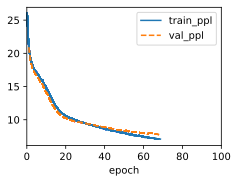

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
emb_len=len(data.vocab)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = NoClipTrainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

# 10. Replace the activation function used in this section with ReLU and repeat the experiments in this section. Do we still need gradient clipping? Why?

In [ ]:
class ReLURNNScratch(RNNScratch):  #@save
        
    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.relu(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = ReLURNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

In [ ]:
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = NoClipTrainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)